# How To Ensemble OOF
In this notebook, we learn how to use `forward selection` to ensemble OOF. First build lots of models using the same KFolds (i.e. use same `seed`). Next save all the oof files as `oof_XX.csv` and submission files as `sub_XX.csv` where the oof and submission share the same `XX` number. Then save them in a Kaggle dataset and run the code below.

The ensemble begins with the model of highest oof AUC. Next each other model is added one by one to see which additional model increases ensemble AUC the most. The best additional model is kept and the process is repeated until the ensemble AUC doesn't increase.

In [13]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
PATH = 'pppm/'
FILES = os.listdir(PATH)

OOF = np.sort( [f for f in FILES if 'oof' in f] )
OOF_CSV = [pd.read_pickle(PATH+k).sort_values('id') for k in OOF]

print('We have %i oof files...'%len(OOF))
print(); print(OOF)

We have 11 oof files...

['oof_1dcnn.pkl' 'oof_2dcnn.pkl' 'oof_df-simcse-anchor.pkl'
 'oof_df_bfp_anchor.pkl' 'oof_df_deberta_l_v3_anchor.pkl'
 'oof_df_electora-anchor.pkl' 'oof_df_funnel_l_anchor.pkl'
 'oof_df_pfp64_anchor.pkl' 'oof_lgbm.pkl' 'oof_mlp.pkl' 'oof_wop.pkl']


In [16]:
import scipy as sp
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score

In [17]:
x = np.zeros(( len(OOF_CSV[0]),len(OOF) ))
for k in range(len(OOF)):
    x[:,k] = OOF_CSV[k].pred.values

    
TRUE = OOF_CSV[0].score.values

In [18]:
all = []
for k in range(x.shape[1]):
    #print(OOF_CSV[0].Pawpularity)
    #print(x[:,k])
    auc = get_score(OOF_CSV[0].score,x[:,k])
    all.append(auc)
    print('Model ' + OOF[k] + ' has score = %.4f'%(auc))
    
m = [np.argmax(all)]; w = []

Model oof_1dcnn.pkl has score = 0.8543
Model oof_2dcnn.pkl has score = 0.8541
Model oof_df-simcse-anchor.pkl has score = 0.8133
Model oof_df_bfp_anchor.pkl has score = 0.8195
Model oof_df_deberta_l_v3_anchor.pkl has score = 0.8273
Model oof_df_electora-anchor.pkl has score = 0.8288
Model oof_df_funnel_l_anchor.pkl has score = 0.8188
Model oof_df_pfp64_anchor.pkl has score = 0.8208
Model oof_lgbm.pkl has score = 0.8530
Model oof_mlp.pkl has score = 0.8543
Model oof_wop.pkl has score = 0.8530


# Build OOF Ensemble. Maximize CV Score

In [19]:
old = np.max(all); 

RES = 200; 
PATIENCE = 10; 
TOL = 0.0003
DUPLICATES = False

print('Ensemble AUC = %.4f by beginning with model %i'%(old,m[0]))
print()

for kk in range(len(OOF)):
    
    # BUILD CURRENT ENSEMBLE
    md = x[:,m[0]]
    for i,k in enumerate(m[1:]):
        md = w[i]*x[:,k] + (1-w[i])*md
        
    # FIND MODEL TO ADD
    mx = 0; mx_k = 0; mx_w = 0
    print('Searching for best model to add... ')
    
    # TRY ADDING EACH MODEL
    for k in range(x.shape[1]):
        print(k,', ',end='')
        if not DUPLICATES and (k in m): continue
            
        # EVALUATE ADDING MODEL K WITH WEIGHTS W
        bst_j = 0; bst = 0; ct = 0
        for j in range(RES):
            tmp = j/RES*x[:,k] + (1-j/RES)*md
            auc = get_score(TRUE,tmp)
            if auc>bst:
                bst = auc
                bst_j = j/RES
            else: ct += 1
            if ct>PATIENCE: break
        if bst>mx:
            mx = bst
            mx_k = k
            mx_w = bst_j
            
    # STOP IF INCREASE IS LESS THAN TOL
    inc = mx-old
    if inc<=TOL: 
        print(); print('No increase. Stopping.')
        break
        
    # DISPLAY RESULTS
    print(); #print(kk,mx,mx_k,mx_w,'%.5f'%inc)
    print('Ensemble AUC = %.4f after adding model %i with weight %.3f. Increase of %.4f'%(mx,mx_k,mx_w,inc))
    print()
    
    old = mx; m.append(mx_k); w.append(mx_w)

Ensemble AUC = 0.8543 by beginning with model 0

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 
No increase. Stopping.


In [20]:
print('We are using models',OOF[m])
print('with weights',w)
print('and achieve ensemble RMSE = %.6f'%old)

We are using models ['oof_1dcnn.pkl']
with weights []
and achieve ensemble RMSE = 0.854318


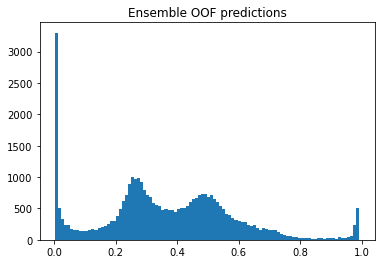

In [21]:
md = x[:,m[0]]
for i,k in enumerate(m[1:]):
    md = w[i]*x[:,k] + (1-w[i])*md
plt.hist(md,bins=100)
plt.title('Ensemble OOF predictions')
plt.show()

In [22]:
def _upd_score_between(data, thresholds, value):
    """\o/"""
    mask_th = data.between(*thresholds, inclusive='both')
    data[mask_th] = value


def upd_score(data, th_dict=None):
    """\o/"""
    if isinstance(data, pd.Series):
        result = data.copy()
    else:
        return data

    if not th_dict:        
        th_dict = {
            '0': 0.02,
            '.25': (0.25, 0.27),
            '.50': (0.50, 0.52),
            '.75': (0.75, 0.77),
            '1': 0.98
        }

    if isinstance(th_dict, dict):    
        th0 = th_dict.get('0')
        th25 = th_dict.get('.25')
        th50 = th_dict.get('.50')
        th75 = th_dict.get('.75')
        th100 = th_dict.get('1')
    else:
        return data

    if th0:
        if isinstance(th0, float):
            th0 = (result.min(), th0)
        
        if isinstance(th0, tuple):
            _upd_score_between(result, th0, 0)
    
    if th25 and isinstance(th25, tuple):
        _upd_score_between(result, th25, 0.25)
    
    if th50 and isinstance(th50, tuple):
        _upd_score_between(result, th50, 0.50)
            
    if th75 and isinstance(th75, tuple):
        _upd_score_between(result, th75, 0.75)
            
    if th100:
        if isinstance(th100, float):
            th100 = (th100, result.max())
        
        if isinstance(th100, tuple):
            _upd_score_between(result, th100, 1)

    return result

In [26]:
md

array([0.31331754, 0.40050915, 0.25624415, ..., 0.00538167, 0.00615615,
       0.36896196])

In [29]:
md*1.2

array([0.37598104, 0.48061098, 0.30749298, ..., 0.00645801, 0.00738738,
       0.44275435])

In [31]:
auc = get_score(TRUE,md*1.5)
print(auc)

0.8543179857269517


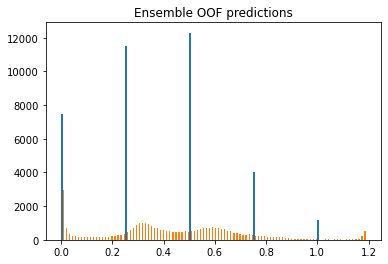

In [32]:
plt.hist((TRUE,md*1.2),bins=100)
plt.title('Ensemble OOF predictions')
plt.show()

In [ ]:
df = OOF_CSV[0].copy()
df.pred = md
df.to_csv('ensemble_oof_m_j.csv',index=False)

# Load SUB Files

In [ ]:
SUB = np.sort( [f for f in FILES if 'sub' in f] )
SUB_CSV = [pd.read_csv(PATH+k) for k in SUB]

print('We have %i submission files...'%len(SUB))
print(); print(SUB)

In [ ]:
# VERFIY THAT SUBMISSION FILES MATCH OOF FILES
a = np.array( [ int( x.split('_')[-1].split('.')[0]) for x in SUB ] )
b = np.array( [ int( x.split('_')[-1].split('.')[0]) for x in OOF ] )
if len(a)!=len(b):
    print('ERROR submission files dont match oof files')
else:
    for k in range(len(a)):
        if a[k]!=b[k]: print('ERROR submission files dont match oof files')

In [ ]:
y = np.zeros(( len(SUB_CSV[0]),len(SUB) ))
for k in range(len(SUB)):
    y[:,k] = SUB_CSV[k].target.values

# Build SUB Ensemble

In [ ]:
md2 = y[:,m[0]]
for i,k in enumerate(m[1:]):
    md2 = w[i]*y[:,k] + (1-w[i])*md2
plt.hist(md2,bins=100)
plt.show()

In [ ]:
df = SUB_CSV[0].copy()
df.target = md2
df.to_csv('ensemble_subv2.csv',index=False)